## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [287]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [288]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

      age  sibsp  parch  ticket      fare    cabin embarked boat body  \
0      29      0      0   24160  211.3375       B5        S    2    ?   
1  0.9167      1      2  113781    151.55  C22 C26        S   11    ?   
2       2      1      2  113781    151.55  C22 C26        S    ?    ?   
3      30      1      2  113781    151.55  C22 C26        S    ?  135   
4      25      1      2  113781    151.55  C22 C26        S    ?    ?   

                         home.dest  
0                     St Louis, MO  
1  Montreal, PQ / Chesterville, ON  
2  Montreal, PQ / Chesterville, ON  
3  Montreal, PQ / Chesterville, ON  
4  Montreal, PQ / Chesterville, ON

In [289]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [290]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [291]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [292]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [293]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

pclass  survived     sex      age  sibsp  parch      fare cabin embarked  \
0       1         1  female  29.0000      0      0  211.3375    B5        S   
1       1         1    male   0.9167      1      2  151.5500   C22        S   
2       1         0  female   2.0000      1      2  151.5500   C22        S   
3       1         0    male  30.0000      1      2  151.5500   C22        S   
4       1         0  female  25.0000      1      2  151.5500   C22        S   

    title  
0    Miss  
1  Master  
2    Miss  
3      Mr  
4     Mrs

In [294]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [295]:
target = 'survived'

In [296]:
vars_num = [i for i in data.columns if data[i].dtype != "O" and i != 'survived']

vars_cat = [i for i in data.columns if data[i].dtype == "O"]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


In [297]:
vars_num

['pclass', 'age', 'sibsp', 'parch', 'fare']

In [298]:
vars_cat

['sex', 'cabin', 'embarked', 'title']

### Find missing values in variables

In [299]:
# first in numerical variables
data[(data[vars_num].isnull().sum() > 0).index].isnull().mean().sort_values(ascending=False)


age       0.200917
fare      0.000764
pclass    0.000000
sibsp     0.000000
parch     0.000000
dtype: float64

In [300]:
# now in categorical variables

data[(data[vars_cat].isnull().sum() > 0).index].isnull().mean().sort_values(ascending=False)

cabin       0.774637
embarked    0.001528
sex         0.000000
title       0.000000
dtype: float64

### Determine cardinality of categorical variables

<AxesSubplot:>

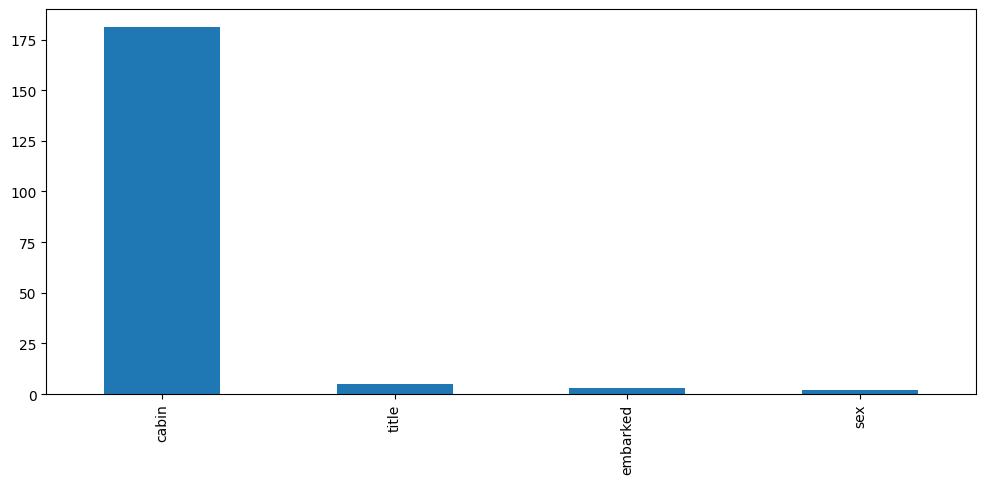

In [301]:
data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

### Determine the distribution of numerical variables

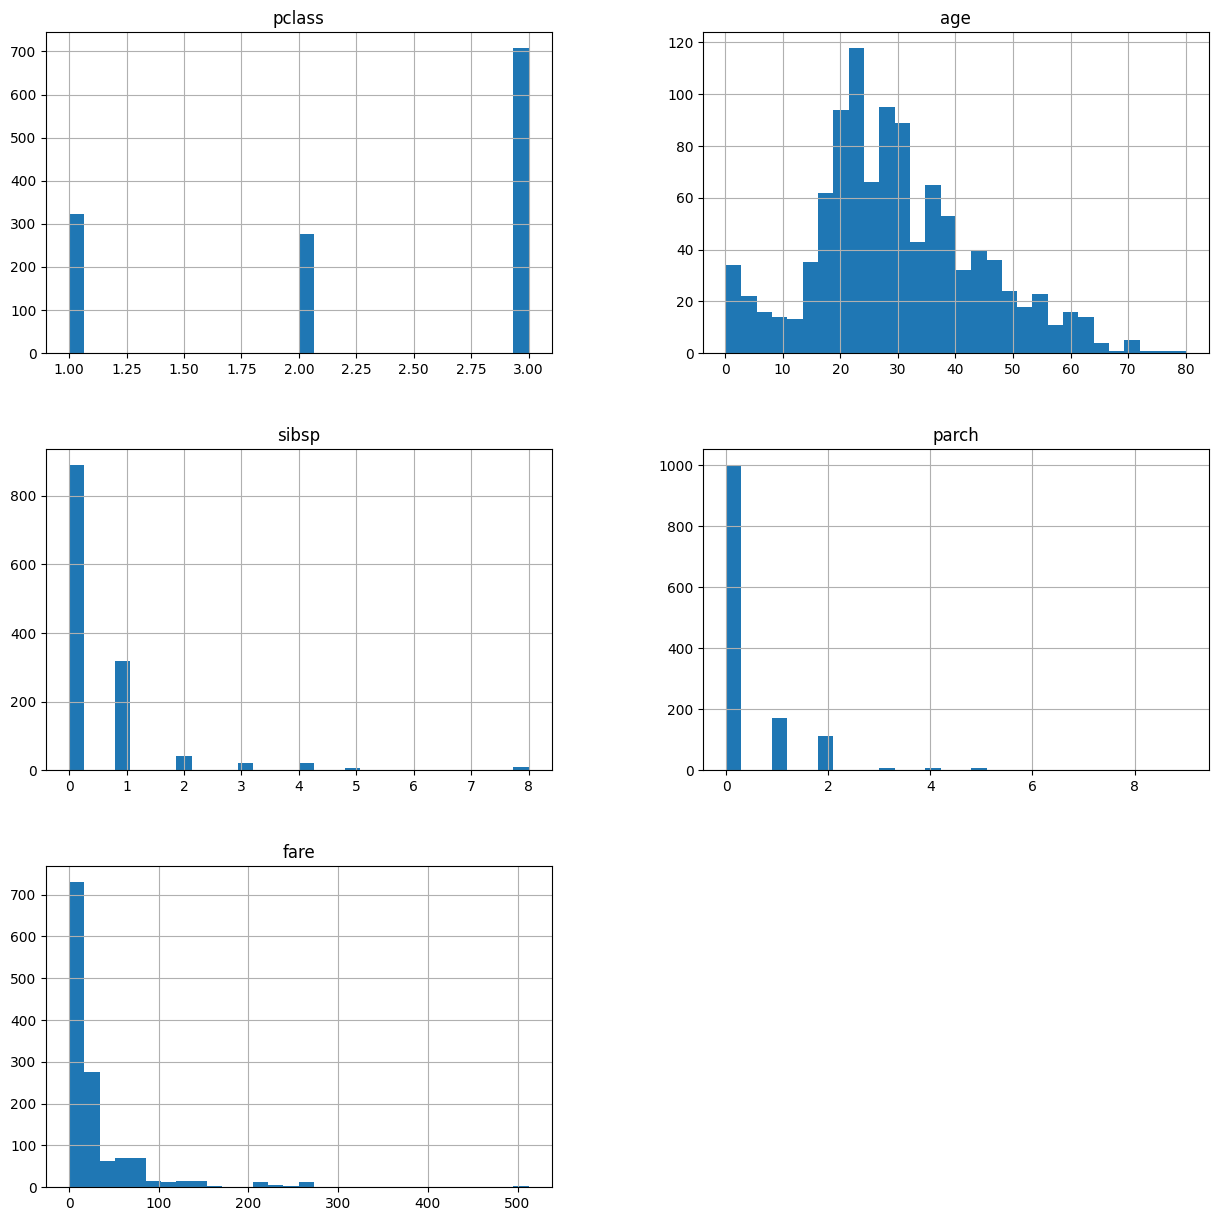

In [302]:
data[vars_num].hist(bins=30, figsize=(15,15))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [303]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [304]:
data["cabin"] = data["cabin"].str[0]

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [305]:
for i in vars_num:
    data[i + "_na"] = data[i].isna()*1
    data[i].fillna(value = data[i].median(), inplace = True)


### Replace Missing data in categorical variables with the string **Missing**

In [306]:
for i in vars_cat:
    data[i].fillna(value = "Missing", inplace=True)

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [307]:
keep_labels = {}
for i in vars_cat:
    tmp = data.groupby(i)['survived'].count() / len(data)
    print(tmp[tmp < .05].index)
    keep_labels[i] = tmp[tmp > .05].index

for i in keep_labels:
    data = data[data[i].isin(keep_labels[i])]

Index([], dtype='object', name='sex')
Index(['A', 'B', 'D', 'E', 'F', 'G', 'T'], dtype='object', name='cabin')
Index(['Missing'], dtype='object', name='embarked')
Index(['Master', 'Other'], dtype='object', name='title')


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [308]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [312]:
for i in vars_cat:
    for j in range(len(data[i].unique())-1):
        print(f'{i}_{j}')
        data[f'{i}_{j}'] = (data[i] == data[i].unique()[j])*1
        
final_data = data.drop(vars_cat, axis=1).reset_index()


sex_0
cabin_0
embarked_0
embarked_1
title_0
title_1


In [313]:
final_data

index  pclass  survived   age  sibsp  parch      fare  pclass_na  \
0         2       1         0   2.0      1      2  151.5500          0   
1         3       1         0  30.0      1      2  151.5500          0   
2         4       1         0  25.0      1      2  151.5500          0   
3         8       1         1  53.0      2      0   51.4792          0   
4         9       1         0  71.0      0      0   49.5042          0   
...     ...     ...       ...   ...    ...    ...       ...        ...   
1028   1304       3         0  14.5      1      0   14.4542          0   
1029   1305       3         0  28.0      1      0   14.4542          0   
1030   1306       3         0  26.5      0      0    7.2250          0   
1031   1307       3         0  27.0      0      0    7.2250          0   
1032   1308       3         0  29.0      0      0    7.8750          0   

      age_na  sibsp_na  parch_na  fare_na  sex_0  cabin_0  embarked_0  \
0          0         0         0        0      1        1           1   
1          0         0         0        0      0        1           1   
2          0         0         0        0      1        1           1   
3          0         0         0        0      1        1           1   
4          0         0         0        0      0        0           0   
...      ...       ...       ...      ...    ...      ...         ...   
1028       0         0         0        0      1        0           0   
1029       1         0         0        0      1        0           0   
1030       0         0         0        0      0        0           0   
1031       0         0         0        0      0        0           0   
1032       0         0         0        0      0        0           1   

      embarked_1  title_0  title_1  
0              0        1        0  
1              0        0        1  
2              0        0        0  
3              0        0        0  
4              1        0        1  
...          ...      ...      ...  
1028           1        1        0  
1029           1        1        0  
1030           1        0        1  
1031           1        0        1  
1032           0        0        1  

[1033 rows x 18 columns]

### Scale the variables

- Use the standard scaler from Scikit-learn

In [314]:
scaler = StandardScaler()
scaler.fit(final_data.drop(['survived'],axis = 1))


scale_data = pd.DataFrame(scaler.transform(final_data.drop(['survived'],axis = 1)))

scale_data.columns = final_data.drop(['survived'],axis = 1).columns
scale_data['survived'] = final_data['survived']
scale_data

index    pclass       age     sibsp     parch      fare  pclass_na  \
0    -2.078565 -2.016692 -2.429401  0.581825  1.899186  2.963041        0.0   
1    -2.075693 -2.016692  0.079356  0.581825  1.899186  2.963041        0.0   
2    -2.072821 -2.016692 -0.368636  0.581825  1.899186  2.963041        0.0   
3    -2.061335 -2.016692  2.140122  1.612742 -0.371484  0.596182        0.0   
4    -2.058463 -2.016692  3.752895 -0.449093 -0.371484  0.549470        0.0   
...        ...       ...       ...       ...       ...       ...        ...   
1028  1.660402  0.704723 -1.309420  0.581825 -0.371484 -0.279528        0.0   
1029  1.663273  0.704723 -0.099841  0.581825 -0.371484 -0.279528        0.0   
1030  1.666145  0.704723 -0.234238 -0.449093 -0.371484 -0.450512        0.0   
1031  1.669017  0.704723 -0.189439 -0.449093 -0.371484 -0.450512        0.0   
1032  1.671888  0.704723 -0.010242 -0.449093 -0.371484 -0.435138        0.0   

        age_na  sibsp_na  parch_na   fare_na     sex_0   cabin_0  embarked_0  \
0    -0.547148       0.0       0.0 -0.031129  1.344271  3.276986    0.627744   
1    -0.547148       0.0       0.0 -0.031129 -0.743897  3.276986    0.627744   
2    -0.547148       0.0       0.0 -0.031129  1.344271  3.276986    0.627744   
3    -0.547148       0.0       0.0 -0.031129  1.344271  3.276986    0.627744   
4    -0.547148       0.0       0.0 -0.031129 -0.743897 -0.305158   -1.593007   
...        ...       ...       ...       ...       ...       ...         ...   
1028 -0.547148       0.0       0.0 -0.031129  1.344271 -0.305158   -1.593007   
1029  1.827659       0.0       0.0 -0.031129  1.344271 -0.305158   -1.593007   
1030 -0.547148       0.0       0.0 -0.031129 -0.743897 -0.305158   -1.593007   
1031 -0.547148       0.0       0.0 -0.031129 -0.743897 -0.305158   -1.593007   
1032 -0.547148       0.0       0.0 -0.031129 -0.743897 -0.305158    0.627744   

      embarked_1   title_0   title_1  survived  
0      -0.457823  1.944841 -1.344271         0  
1      -0.457823 -0.514181  0.743897         0  
2      -0.457823 -0.514181 -1.344271         0  
3      -0.457823 -0.514181 -1.344271         1  
4       2.184250 -0.514181  0.743897         0  
...          ...       ...       ...       ...  
1028    2.184250  1.944841 -1.344271         0  
1029    2.184250  1.944841 -1.344271         0  
1030    2.184250 -0.514181  0.743897         0  
1031    2.184250 -0.514181  0.743897         0  
1032   -0.457823 -0.514181  0.743897         0  

[1033 rows x 18 columns]

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [318]:
X_train, X_test, y_train, y_test = train_test_split(
    final_data.drop('survived', axis=1),  # predictors
    final_data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

clf = LogisticRegression(C = 0.0005, random_state=0, max_iter=100000000).fit(X_train,y_train)


## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [332]:
print(accuracy_score(clf.predict(X_test),y_test))

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1], average=None))

0.7246376811594203
0.6792409164545243


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**